# CT2FE example 03
## microCT stack to linear-elastic voxel microFE model:
- cortical bone dataset scanned at the TOMCAT beamline of the Swiss Light Source
- constant bone material properties
- FE solution in CalculiX
14.02.2021

For info on the solver see the Calculix homepage:
http://www.calculix.de/

## Basic configurations

In [20]:
import os
import numpy as np
import tifffile
import dxchange
import matplotlib
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

matplotlib.rcParams['figure.dpi'] = 100

#### Inputs and parameters definition

In [21]:
input_file = 'test_data/example_01/bone_mask_8bit/scan-sample_15-3-crop_c0001.tif'
filename_in, ext = os.path.split(input_file)
vs = [6.5e-3, 6.5e-3, 6.5e-3] # voxel size

## Pre-processing
#### Read stack of TIFFs
The model has been preliminary thresholded and cropped in Fiji

In [5]:
# search all files in parent folder; create filenames list
tifffiles = [os.path.join(os.path.dirname(input_file), f) for f in os.listdir(os.path.dirname(input_file)) if os.path.isfile(os.path.join(os.path.dirname(input_file), f))]
tifffiles.sort()

# load stack using tifffile
data_3D = tifffile.imread(tifffiles)

In [7]:
data_3D_shape = data_3D.shape[:]

Have a look at the input data

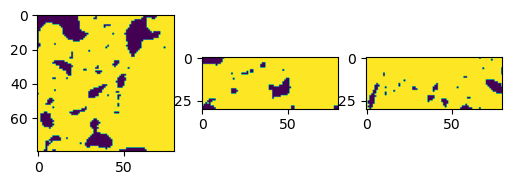

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(data_3D[15, :, :])
ax2.imshow(data_3D[:, 40, :])
ax3.imshow(data_3D[:, :, 40])

#### Add embedding

#### Add steel caps

In [10]:
def add_cap(data_3D, cap_thickness, cap_val):
    # Add caps of voxels with given GV to the input 3D data.
    # Caps are added on both ends along the Z-direction (first dataset dimension).
    data_3D_cap = np.ones([data_3D.shape[0]+2*cap_thickness, data_3D.shape[1], data_3D.shape[2]], data_3D.dtype)*cap_val
    data_3D_cap[cap_thickness:-cap_thickness, :, :] = data_3D
    return data_3D_cap

In [11]:
cap_thickness = 2 # [pixels]
cap_val = 150 # GV assigned to the cap material
data_3D_cap = add_cap(data_3D, cap_thickness, cap_val)

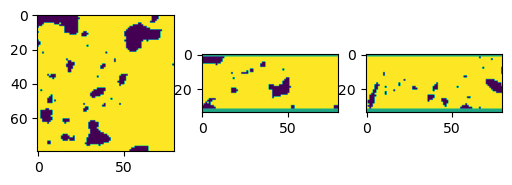

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(data_3D_cap[15, :, :])
ax2.imshow(data_3D_cap[:, 40, :])
ax3.imshow(data_3D_cap[:, :, 40])

#### Write modified 3D data
Write stack of TIFFs using `dxchange` module

In [13]:
cap_file = 'test_data/example_01/mask_8bit_cap/scan-sample_15-3-crop_c'
dxchange.writer.write_tiff_stack(data_3D_cap, fname=cap_file, dtype=None, axis=0, digit=4, start=0, overwrite=False)

#### Visualize material propoerty mapping for the bone tissue

In [22]:
!cat ./material_properties/bone_Econst.inp

** ---------------------------------------------------
** bone.inp
** material property definition with E=18GPa and ν=0.3
** ---------------------------------------------------
** Material definition:
*SOLID SECTION, ELSET=SetName, MATERIAL=MatName
1.
*MATERIAL,NAME=MatName
*ELASTIC
18000, 0.3


The file *bone_Econst.inp* assigns constant elastic material properties to the bone voxels.<br />
In particular:
* Bone tissue Young's modulus: $ E = 18000 $ [MPa]
* Bone tissue Poisson's ratio: $ \nu = 0.3 $

## Stack 2 FE model conversion
The script stack2Abaqus.py takes a stack of TIFF as input and converts the model to Abaqus input file (.INP) for solution in Abaqus or Calculix.

See the script help with the command
`stack2abaqus.py -h`

In [15]:
%run stack2Abaqus.py -h

usage: stack2Abaqus.py [-h] [-vs VOXELSIZE [VOXELSIZE ...]]
                       [-k [KEYWORDS [KEYWORDS ...]]] [--bits BITS]
                       [--eltype ELTYPE] [-p [PROPERTY [PROPERTY ...]]]
                       [-pr [PRANGE [PRANGE ...]]] [-t TEMPLATE] [-v VERBOSE]
                       filein fileout

Script to create ABAQUS Finite Element (FE) input file from 3D voxel model.

The scripts converts the voxels of a 3D input model file to the hexahedra
of a voxel-FE input file for FE simulations of solid mechanics problems.

The output of this script is an input file (.INP) in ABAQUS syntax
that can be solved using ABAQUS or CALCULIX.

The script allows the user to define a material mapping strategy
for the direct conversion of local Grey Values (GVs) of the input 3D model
to the local material properties of the FE model.

The definition of material mapping laws is done using separate template file(s).
See "prop.inp" and "property_temp_bone.inp" for examples.

Boundary condi

#### Visualize template CalculiX analisys definition

In [23]:
template_inp = './input_templates/tmp.inp'
!cat {template_inp}

** ---------------------------------------------------
** The STEP module defines the analysis steps and associated output requests. More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
** Analysis definition:
*STEP
*STATIC
*BOUNDARY
** All displacements fixed at bottom:
NODES_B, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_T, 3, 3, -0.002
** Output request:
** Nodal displacements; Element stress; Reaction Force sum on NODES_B
*NODE FILE
U
*EL FILE
S
*NODE PRINT, TOTALS=ONLY, NSET=NODES_B
RF
*END STEP


In [26]:
input_file = 'test_data/example_01/mask_8bit_cap/scan-sample_15-3-crop_c_0000.tiff'
output_file = 'test_data/example_03/pippo.inp'
filename_out, ext_out = os.path.splitext(output_file)
%run stack2Abaqus.py {input_file} {output_file} -vs {vs[0]} {vs[1]} {vs[2]} -k NODE ELEMENT NSET PROPERTY -p './material_properties/bone_Econst.inp' './material_properties/steel.inp' -pr 255:255 150:150 -t {template_inp} -v True

INFO:root:Data loaded with size 34 x 80 x 80
INFO:root:User material properties defined.
INFO:root:Reading Abaqus template file ./input_templates/tmp.inp
INFO:root:Data written to file test_data/example_03/pippo.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [57]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT {filename_out}


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Thu Jul 23 21:43:50 CEST 2020

  The numbers below are estimated upper bounds

  number of:

   nodes:       229635
   elements:       190507
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            8
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:        26244
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie const

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [12]:
import ccx2paraview

In [13]:
ccx2paraview.Converter(filename_out + '.frd', ['vtk']).run()

INFO:root:Reading pippo.frd
INFO:root:212698 nodes
INFO:root:190814 cells
INFO:root:Step 1, time 1.0, U, 3 components, 212698 values
INFO:root:Step 1, time 1.0, S, 6 components, 212698 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 212698 values
INFO:root:1 time increment
INFO:root:Writing pippo.vtk


INFO:root:Step 1, time 1.0, U, 3 components, 212698 values
INFO:root:Step 1, time 1.0, S, 6 components, 212698 values
INFO:root:Step 1, time 1.0, S_Mises, 1 components, 212698 values
INFO:root:Step 1, time 1.0, S_Principal, 3 components, 212698 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 212698 values


Visualize results in Paraview

In [14]:
!paraview test_data/example_03/pippo.vtk

![](test_data/example_01/masked_8bit_cap1.png)

In [28]:
# Calculation of apparent modulus of elasticity from the sum of reaction forces recorded and the ~1% strain (-0.002mm) imposed
# note/questions:
# - the voxelsize given has a factor of 1e3 (6.5e-3 instead of 6.5e-6)
# - the E modulus in the mat. property definition is given in MPa (has a factor 1e3?) 
1e-6*(4.097E+01/(6.5e-3**2*80**2))/(0.002e-3/(6.5e-3*30)) # [GPa]

14.772836538461537